In [1]:
# Import Libraries
import pandas as pd

In [2]:
# Load data
train_df = pd.read_csv('/Users/Aayush/Desktop/kaggle_codes/datasets/nlp-getting-started/train.csv')
test_df = pd.read_csv('/Users/Aayush/Desktop/kaggle_codes/datasets/nlp-getting-started/test.csv')


In [3]:
# See the structure
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<Axes: title={'center': 'Class Balance'}, xlabel='target'>

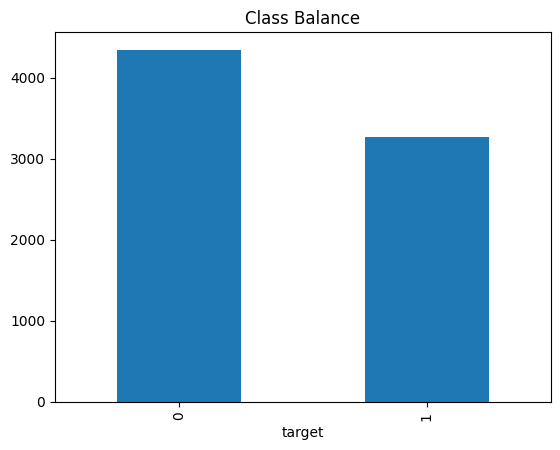

In [4]:
# Class distribution
train_df['target'].value_counts().plot(kind='bar', title='Class Balance')
# this line basically accesses the 'target' column. Then counts how many 0s and 1s there are in  the column and then plots the count as a bar chart.

<Axes: title={'center': 'Tweet Lengths'}, ylabel='Frequency'>

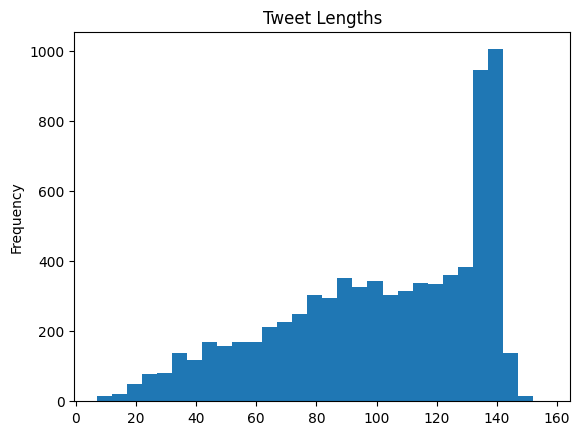

In [5]:
# Length of tweets
train_df['text_len'] = train_df['text'].apply(len) # this adds a new column 'text_len' to 'train_df' where each value is the character length of the tweet
test_df['text_len'] = test_df['text'].apply(len) # same as above for the test set this time
train_df['text_len'].plot(kind='hist', bins=30, title='Tweet Lengths') # Plots a histogram of tweet lengths in the training set and 'bins=30' splits the range into 30 intervals

# -------------------

# this block of code helps us understand the text distribution. We may spot very long tweets or very short tweets. This justifies those using 'text_len' as a feature.

In [6]:
import re
import string
from urllib.parse import urlparse
def cleanText(text):
    text = text.lower()
    # Extract URLs (used later for domain extraction)
    urls = re.findall(r'https?:\/\/\S+', text)
    # re.sub is used to perform substitution using regex
    text = re.sub(r'@[A-Za-z0-9]+','',text) # removes any '@mentions' in text, basically replace any @mentions with '' - empty string
    text = re.sub(r'#','',text) # the same thing - replace the '#' symbol with '' - empty string, but do not remove the text after the '#' as it could be important in the classification
    text = re.sub(r'RT[\s]+','',text) # this removes the 'RT' tag from the beginning of tweets. 'RT' means the tag is a retweet. This is not important for us, and hence removing it keeps the data clean.
    text = re.sub(r'https?:\/\/\S+', '', text)  # same thing as above. This removes URLs from a text
    text = re.sub(r'[^a-z0-9\s]', '', text)  # \s = space
    return text

# this function below extracts the domain name from any url in the tweet
def extractDomain(text):
    urls = re.findall(r'https?:\/\/\S+', text) # this line uses a regular expression to find all the urls in the text
    # https? -> matches http or https
    # :\/\/ -> matches ://
    # \S+ -> matches the rest of the URL -> all non-space characters
    # ----------------
    domains = [urlparse(url).netloc for url in urls] # this line loops through each URL
    # urlparse(url) -> breaks each URL into parts -> domain, protocol, path, etc.
    # netloc -> extracts the domain name from each URL

    return domains[0] if domains else None # if the list 'domains' has at least one domain, then that domain is returned; otherwise 'None' is returned

# ------------------------------------------------------------

# the 'extractDomain' function is an important function for some self-explanatory reasons:
## 1. Many disaster-related tweets link to news or gov sites
## 2. So the domain name is definitely going to be a predictive feature
## 3. And hence this helps our model differentiate b/w real vs. fake disasters

# ------------------------------------------------------------

# clean text
train_df['clean_text'] = train_df['text'].apply(cleanText)
test_df['clean_text'] = test_df['text'].apply(cleanText)
# Extract domain feature
train_df['domain'] = train_df['text'].apply(extractDomain)
test_df['domain'] = test_df['text'].apply(extractDomain)

In [7]:
# this block of code is doing categorical encoding for our 'domain' feature so that our ML model can understand it

from sklearn.preprocessing import LabelEncoder # LabelEncoder -> turns text categories into numbers
# Handle missing values and encode
le = LabelEncoder() # -> an instance of LabelEncoder called 'le' is created

train_df['domain_encoded'] = le.fit_transform(train_df['domain'].fillna('none'))
# .fillna -> replaces missing domain values with the string 'none'
# le.fit_transform -> Fits the encoder to the unique domain strings in training data, then transforms those strings into numeric labels and then stores the result in a new column: domain_encoded

test_df['domain_encoded'] = le.transform(test_df['domain'].fillna('none'))
# This above line only transforms the test data using the same label mapping from training data
# Doesn't call .fit() again -> keeps mappings consistent
# This prevents data leakage and ensures the model sees known labels as the same numbers during inference

# ---------------------------------------

# Why use Label Encoding?
## 1. ML models like LogisticRegression, SVM, etc. don’t accept strings
## 2. Encoding converts domain from a text feature into a numerical feature
## 3. You can now combine it with TF-IDF or other features in your model

# ---------------------------------------

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer -> Converts text into numerical features using TF-IDF (Term Frequency - Inverse Document Frequency).
import scipy
# scipy -> Used for working with sparse matrices; especially to stack features.

tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, stop_words='english')
# This line above creates a TF-IDF vectorizer and:
#             1. includes unigrams (1-word sequences) and bigrams (2-word sequences)
#             2. limits vocabulary size to 10,000 most frequent terms
#             3. removes common English words like “the,” “is,” etc.
# Unigrams capture individual word importance (good for bag-of-words or TF-IDF).
# Bigrams add context — useful for capturing phrases, negations, or multi-word expressions.
X_train = tfidf.fit_transform(train_df['clean_text'])
X_test = tfidf.transform(test_df['clean_text'])
# .fit_transform learns vocabulary from a training set and transforms it into sparse TF-IDF vectors.
# .transform applies the same transformation (with the same vocabulary) to the test set.

# Convert domain_encoded column to 2D arrays
domain_train = train_df[['domain_encoded']].values
domain_test = test_df[['domain_encoded']].values

# Convert to column arrays
text_len_train = train_df[['text_len']].values
text_len_test = test_df[['text_len']].values


# Horizontally stack with TF-IDF matrices
X_train_combined = scipy.sparse.hstack((X_train, domain_train, text_len_train))
X_test_combined = scipy.sparse.hstack((X_test, domain_test, text_len_test))
# hstack() creates a combined sparse matrix with shape [n_samples, num_features + 2]

# Extracts the target labels
y_train = train_df['target']

In [9]:
from sklearn.linear_model import LogisticRegression
# LogisticRegression -> A linear model for binary (or multi-class) classification.
from sklearn.metrics import classification_report
# classification_report -> Gives detailed performance metrics like precision, recall, and F1-score for each class.

model = LogisticRegression(max_iter=200) # Creates an instance of Logistic Regression.
# max_iter=200 -> Increases the number of training iterations (default is 100) — useful when your data is high-dimensional (like with TF-IDF).

# Fits (trains) the model using your combined training features and labels.
model.fit(X_train_combined, y_train)

# Optional: Evaluate on training data
y_pred = model.predict(X_train_combined)
print(classification_report(y_train, y_pred))



              precision    recall  f1-score   support

           0       0.85      0.95      0.90      4342
           1       0.93      0.78      0.84      3271

    accuracy                           0.88      7613
   macro avg       0.89      0.86      0.87      7613
weighted avg       0.88      0.88      0.88      7613



In [10]:
# Predict on a test set
test_preds = model.predict(X_test_combined)

# Create submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_preds
})

submission.to_csv('submission.csv', index=False)
